In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.utils.data as data
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import logging
import cv2
import random
import torch.nn.functional as F
import math

%matplotlib inline
plt.ion()

In [2]:
class CubDataset(data.Dataset):
    def __init__(self,
                 root='/workspace/data/CUB_200_2011/',
                 transform=None,
                 test=False
                 ):
        self.root = root
        self.transform = transform
        self.x = []
        self.y = []
        self.load_data_list(test)

    def load_data_list(self, test):
        images = open(os.path.join(self.root, 'images.txt')).readlines()
        labels = open(os.path.join(self.root, 'image_class_labels.txt')).readlines()
        with open(os.path.join(self.root, 'train_test_split.txt')) as f:
            for line in f.readlines():
                lines = line.strip().split(' ')
                if test and lines[1]=='0':
                    self.x.append(os.path.join(self.root, 'images', images[int(lines[0])-1].strip().split(' ')[1]))
                    self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
                if not test and lines[1]=='1':
                    self.x.append(os.path.join(self.root, 'images', images[int(lines[0])-1].strip().split(' ')[1]))
#                     self.x.append(os.path.join(self.root, 'images_guass_noise', images[int(lines[0])-1].strip().split(' ')[1]))
#                     self.x.append(os.path.join(self.root, 'images_s_p', images[int(lines[0])-1].strip().split(' ')[1]))
#                     self.x.append(os.path.join(self.root, 'images_poisson', images[int(lines[0])-1].strip().split(' ')[1]))
                    self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
#                     self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
#                     self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
#                     self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, item):
        filepath = self.x[item]
        label = self.y[item]

        # image = Image.open(filepath)
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(448),
    transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomVerticalFlip(0.5),
    transforms.RandomCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#     transforms.Normalize([0.485, 0.465, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(448),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

batch_size = 12
num_classes = 200
num_attentions = 32
beta = 1e-4

trainset = CubDataset(transform=train_transform)
testset = CubDataset(transform=test_transform, test=True)


trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=8)

os.environ["CUDA_VISIBLE_DEVICES"]="0, 1"

torch.Size([12, 3, 448, 448])


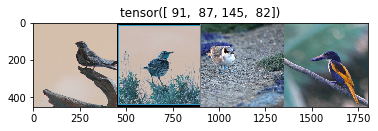

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     inp = inp.transpose((0, 3, 2, 1))

#     mean = np.array([0.485, 0.465, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = inp[...,::-1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(trainloader))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=str(classes[:4]))

In [5]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class Attention(nn.Module):
    
    def __init__(self, in_channels, out_channels, **kwargs):
        super(Attention, self).__init__()
        self.conv1 = BasicConv2d(in_channels, 512, kernel_size=1)
        self.conv2 = BasicConv2d(512, num_attentions, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, num_attentions=32, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # [64, 112, 112]
        self.layer1 = self._make_layer(block, 64, layers[0])
        # [64, 112, 112]
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # [128, 56, 56]
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # [256, 28, 28]
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # [512, 14, 14]
        
#         self.attention = BasicConv2d(512 * block.expansion, num_attentions, kernel_size=1)
        self.attention = Attention(512 * block.expansion, num_attentions)
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion * num_attentions, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def _bilinear_attention_pooling(self, x, a):
        x = x.view(x.size(0), x.size(1), -1)
        a = a.view(a.size(0), a.size(1), -1)
        x = torch.bmm(x, torch.transpose(a, 1, 2)) / (12**2)
        x = x.view(x.size(0), -1)
        x = torch.sqrt(x+1e-12)
        x = F.normalize(x)
        return x

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        att = self.attention(x)
        
        x = self._bilinear_attention_pooling(x, att)
        f = x
        
        x = x.view(x.size(0), -1)
        x = self.fc(x*100)
        
        return x, f, att


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet50'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet101'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [6]:
def attention_crop(attention_maps):
    batch_size, num_parts, height, width = attention_maps.shape
    thetas = []
    for i in range(batch_size):
        attention_map = attention_maps[i]
        part_weights = torch.mean(torch.mean(attention_map, dim=1), dim=1)
        part_weights = torch.sqrt(part_weights)
        part_weights = part_weights / torch.sum(part_weights)
        selected_index = torch.multinomial(part_weights, 1, replacement=False, out=None)[0]

        mask = attention_map[selected_index, :, :]

        threshold = random.uniform(0.4, 0.6)
        itemindex = torch.nonzero(mask >= mask.max() * threshold)
        ymin = itemindex[:, 0].min().item() / height - 0.1
        ymax = itemindex[:, 0].max().item() / height + 0.1
        xmin = itemindex[:, 1].min().item() / width - 0.1
        xmax = itemindex[:, 1].max().item() / width + 0.1
        a = xmax - xmin
        e = ymax - ymin
        # crop weight=height
        pad = abs(a-e)/2.
        if a <= e:
            a = e
            xmin -= pad
        else:
            e = a
            ymin -= pad
        
        c = 2*xmin - 1 + a
        f = 2*ymin - 1 + e
        theta = np.asarray([[a, 0, c], [0, e, f]], dtype=np.float32)
        thetas.append(theta)
    thetas = np.asarray(thetas, np.float32)
    return thetas


def attention_drop(attention_maps):
    batch_size, num_parts, height, width = attention_maps.shape
    masks = []
    for i in range(batch_size):
        attention_map = attention_maps[i]
        part_weights = torch.mean(torch.mean(attention_map, dim=1), dim=1)
        part_weights = torch.sqrt(part_weights)
        part_weights = part_weights / torch.sum(part_weights)
        selected_index = torch.multinomial(part_weights, 1, replacement=False, out=None)[0]

        mask = attention_map[selected_index, :, :]
        # soft mask
        threshold = random.uniform(0.2, 0.5)
        mask = (mask < threshold * mask.max())
        masks.append(mask)
#     masks = np.asarray(masks, dtype=np.float32)
    masks = torch.stack(masks)
    masks = masks.type(torch.float32)
    masks = torch.unsqueeze(masks, dim=1)
    return masks

def mask2bbox(attention_maps):
    height = attention_maps.shape[2]
    width = attention_maps.shape[3]
    thetas = []
    for i in range(attention_maps.shape[0]):
        mask = attention_maps[i][0]
        max_activate = mask.max()
        min_activate = 0.1 * max_activate
#         mask = (mask >= min_activate)
        itemindex = torch.nonzero(mask >= min_activate)
        ymin = itemindex[:, 0].min().item() / height - 0.05
        ymax = itemindex[:, 0].max().item() / height + 0.05
        xmin = itemindex[:, 1].min().item() / width - 0.05
        xmax = itemindex[:, 1].max().item() / width + 0.05
        a = xmax - xmin
        e = ymax - ymin
        # crop weight=height
        pad = abs(a-e)/2.
        if a <= e:
            a = e
            xmin -= pad
        else:
            e = a
            ymin -= pad
        c = 2*xmin - 1 + a
        f = 2*ymin - 1 + e
        theta = np.asarray([[a, 0, c], [0, e, f]], dtype=np.float32)
        thetas.append(theta)
    thetas = np.asarray(thetas, np.float32)
    return thetas

In [7]:
def train(model, criterion, optimizer, schedler, epochs, train_log='train_log', val_log='val_log', saved_model='model'):
    best_acc = 0.0
    best_main_acc = 0.0
    best_crop_acc = 0.0
    feature_center = torch.zeros(num_classes, num_attentions * 2048).cuda()
    for epoch in range(epochs):
        begin = time.time()
        logs = open(train_log, 'a')
        model.train()
        running_corrects = np.array([0.0, 0.0, 0.0])
        running_loss = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
        schedler.step()
        for i, (images, labels) in enumerate(trainloader):
            start = time.time()
            images = images.cuda()
            labels = labels.cuda()

            outputs, feature_matrix, attention_map = model(images)
            batch_loss = criterion[0](outputs, labels)
            center_loss = criterion[1](feature_matrix, feature_center[labels])
            
            feature_center[labels] += beta * (feature_matrix.detach() - feature_center[labels])
            running_loss[0] += batch_loss.item() * images.size(0)
            running_loss[1] += center_loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects[0] += torch.sum(preds == labels.data)
            
            # attention crop
            attention_map = F.upsample_bilinear(attention_map, size=(images.size(2), images.size(3)))
            thetas = attention_crop(attention_map.detach())
            thetas = torch.from_numpy(thetas).cuda()
            #     grid = F.affine_grid(theta, img.size())
            grid = F.affine_grid(thetas, images.size())
            crop_images = F.grid_sample(images, grid)
            outputs1, _, _ = model(crop_images)
            crop_loss = criterion[0](outputs1, labels)
            running_loss[2] += crop_loss.item() * images.size(0)
            _, preds = torch.max(outputs1, 1)
            running_corrects[1] += torch.sum(preds == labels.data)
            
            # attention drop
            drop_mask = attention_drop(attention_map.detach())
            drop_images = images * drop_mask
            outputs2, _, _ = model(drop_images)
            drop_loss = criterion[0](outputs2, labels)
            running_loss[3] += drop_loss.item() * images.size(0)
            _, preds = torch.max(outputs2, 1)
            running_corrects[2] += torch.sum(preds == labels.data)
            
            all_loss = (batch_loss + crop_loss + drop_loss) / 3 + center_loss
            running_loss[4] += all_loss.item() * images.size(0)
            optimizer.zero_grad()
            all_loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print('attention map max: {:.4f}, min: {:.4f}'.format(attention_map.max(), attention_map.min()))
                print('feature matrix max: {:.4f}, min: {:.4f}'.format(feature_matrix.max(), feature_matrix.min()))
                print('feature center max: {:.4f}, min: {:.4f}'.format(feature_center.max(), feature_center.min()))
                print('Epoch: {}/{}, Iter: {}/{:.0f}, Main Loss: {:.4f}, Center Loss: {:.4f}, crop Loss: {:.4f}, drop Loss: {:.4f}, All Loss: {:.4f}, Time: {:.4f}s/batch'.format(epoch, epochs, i, trainset.__len__()/batch_size+1, 
                             batch_loss.item(), center_loss.item(), 
                             crop_loss.item(), drop_loss.item(), 
                             all_loss.item(), time.time()-start))
        epoch_loss = running_loss / trainset.__len__()
        epoch_acc = running_corrects / trainset.__len__()

        log = '**Train Epoch: {}/{}, Main Loss: {:.4f}, Center Loss: {:.4f}, \
               crop Loss: {:.4f}, drop Loss: {:.4f}, All Loss: {:.4f}, \
               Main Acc: {:.0f}/{}, {:.4f}, Crop Acc: {:.0f}/{}, {:.4f}, \
               Drop Acc: {:.0f}/{}, {:.4f}, \
               Time: {:.0f}s'.format(epoch, epochs,
                                     epoch_loss[0], epoch_loss[1], epoch_loss[2], 
                                     epoch_loss[3], epoch_loss[4], 
                                     running_corrects[0], trainset.__len__(), epoch_acc[0], 
                                     running_corrects[1], trainset.__len__(), epoch_acc[1],
                                     running_corrects[2], trainset.__len__(), epoch_acc[2],
                                     time.time()-begin)
#         save_feature_map(epoch, model, saved_model.split('/')[-1])
        
        print(log)
        logs.write(log+'\n')
        val_acc0, val_acc1, val_acc2 = validate(model, testloader, writed_log=val_log)
        torch.save({
                'state_dict': model.module.state_dict(),
                'acc0': val_acc0,
                'acc1': val_acc1,
                'acc2': val_acc2
            }, '{}_latest.pkl'.format(saved_model))
        if best_main_acc < val_acc0:
            best_main_acc = val_acc0
            torch.save({
                'state_dict': model.module.state_dict(),
                'acc0': val_acc0,
                'acc1': val_acc1,
                'acc2': val_acc2
            }, '{}_best_main_acc.pkl'.format(saved_model))
        if best_crop_acc < val_acc1:
            best_crop_acc = val_acc1
            torch.save({
                'state_dict': model.module.state_dict(),
                'acc0': val_acc0,
                'acc1': val_acc1,
                'acc2': val_acc2
            }, '{}_best_crop_acc.pkl'.format(saved_model))
        if best_acc < val_acc2:
            best_acc = val_acc2
            torch.save({
                'state_dict': model.module.state_dict(),
                'acc0': val_acc0,
                'acc1': val_acc1,
                'acc2': val_acc2
            }, '{}_best_acc.pkl'.format(saved_model))

In [8]:
def validate(model, loader, writed_log='', _type='Val'):
    begin = time.time()
    if writed_log != '':
        logs = open(writed_log, 'a')
    model.eval()
    with torch.no_grad():
        running_corrects = np.array([0.0, 0.0, 0.0])
        running_loss = np.array([0.0, 0.0])
        for i, (images, labels) in enumerate(loader):
            images = images.cuda()
            labels = labels.cuda()

            outputs, _, attention_map = model(images)
            batch_loss = F.cross_entropy(outputs, labels)

            running_loss[0] += batch_loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects[0] += torch.sum(preds == labels.data)

            # mask crop
            attention_map = torch.mean(attention_map, dim=1).unsqueeze(1)
            attention_map = F.upsample_bilinear(attention_map, size=(images.size(2), images.size(3)))
            thetas = mask2bbox(attention_map)
            thetas = torch.from_numpy(thetas).cuda()
            #     grid = F.affine_grid(theta, img.size())
            grid = F.affine_grid(thetas, images.size())
            crop_images = F.grid_sample(images, grid)
            outputs1, _, _ = model(crop_images)
            mask_loss = F.cross_entropy(outputs1, labels)
            running_loss[1] += mask_loss.item() * images.size(0)
            _, preds = torch.max(outputs1, 1)
            running_corrects[1] += torch.sum(preds == labels.data)

            _, preds = torch.max(outputs + outputs1, 1)
            running_corrects[2] += torch.sum(preds == labels.data)

        epoch_loss = running_loss / testset.__len__()
        epoch_acc = running_corrects / testset.__len__()

        log = '**Test, Main Loss: {:.4f}, Mask Loss: {:.4f}, \
               Main Acc: {:.0f}/{}, {:.4f}, Mask Acc: {:.0f}/{}, {:.4f}, \
               Final Acc: {:.0f}/{}, {:.4f}, \
               Time: {:.0f}s'.format(epoch_loss[0], epoch_loss[1], 
                                     running_corrects[0], testset.__len__(), epoch_acc[0], 
                                     running_corrects[1], testset.__len__(), epoch_acc[1],
                                     running_corrects[2], testset.__len__(), epoch_acc[2],
                                     time.time()-begin)
    #         save_feature_map(epoch, model, saved_model.split('/')[-1])

        print(log)
        logs.write(log+'\n')
        return epoch_acc[0], epoch_acc[1], epoch_acc[2]

In [ ]:
model = resnet50(pretrained=True, num_classes=200, num_attentions=32)
model = nn.DataParallel(model)
model = model.cuda()
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
if not os.path.exists('logs/'):
    os.makedirs('logs/')
if not os.path.exists('checkpoints/'):
    os.makedirs('checkpoints/')
train_log = 'logs/train_resnet50'
val_log = 'logs/test_resnet50'
saved_model = 'checkpoints/resnet50'
train(model, (criterion1, criterion2), optimizer, exp_lr_schedler, epochs=100, train_log=train_log, val_log=val_log, saved_model=saved_model)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2622: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


attention map max: 6.5242, min: 0.0000
feature matrix max: 0.0145, min: 0.0000
feature center max: 0.0000, min: 0.0000
Epoch: 0/100, Iter: 0/500, Main Loss: 5.3832, Center Loss: 0.0000, crop Loss: 5.3488, drop Loss: 5.3689, All Loss: 5.3670, Time: 3.8367s/batch
attention map max: 11.3006, min: 0.0000
feature matrix max: 0.0211, min: 0.0000
feature center max: 0.0000, min: 0.0000
Epoch: 0/100, Iter: 100/500, Main Loss: 5.9213, Center Loss: 0.0000, crop Loss: 5.9845, drop Loss: 5.9624, All Loss: 5.9561, Time: 0.5901s/batch
attention map max: 12.8290, min: 0.0000
feature matrix max: 0.0244, min: 0.0000
feature center max: 0.0000, min: 0.0000
Epoch: 0/100, Iter: 200/500, Main Loss: 3.5466, Center Loss: 0.0000, crop Loss: 4.2038, drop Loss: 3.5998, All Loss: 3.7834, Time: 0.5803s/batch
attention map max: 11.6203, min: 0.0000
feature matrix max: 0.0235, min: 0.0000
feature center max: 0.0000, min: 0.0000
Epoch: 0/100, Iter: 300/500, Main Loss: 2.9499, Center Loss: 0.0000, crop Loss: 3.2617, 

attention map max: 11.3078, min: 0.0000
feature matrix max: 0.0305, min: 0.0000
feature center max: 0.0003, min: 0.0000
Epoch: 4/100, Iter: 400/500, Main Loss: 0.9384, Center Loss: 0.0000, crop Loss: 1.2570, drop Loss: 2.6406, All Loss: 1.6120, Time: 0.5809s/batch
**Train Epoch: 4/100, Main Loss: 0.5706, Center Loss: 0.0000,                crop Loss: 1.2297, drop Loss: 1.4379, All Loss: 1.0794,                Main Acc: 5050/5994, 0.8425, Crop Acc: 4184/5994, 0.6980,                Drop Acc: 3794/5994, 0.6330,                Time: 282s
**Test, Main Loss: 0.8864, Mask Loss: 0.8785,                Main Acc: 4564/5794, 0.7877, Mask Acc: 4529/5794, 0.7817,                Final Acc: 4567/5794, 0.7882,                Time: 58s
attention map max: 10.6742, min: 0.0000
feature matrix max: 0.0277, min: 0.0000
feature center max: 0.0003, min: 0.0000
Epoch: 5/100, Iter: 0/500, Main Loss: 0.3676, Center Loss: 0.0000, crop Loss: 1.0572, drop Loss: 1.5708, All Loss: 0.9986, Time: 0.6011s/batch
attenti

attention map max: 10.4872, min: 0.0000
feature matrix max: 0.0304, min: 0.0000
feature center max: 0.0006, min: 0.0000
Epoch: 9/100, Iter: 200/500, Main Loss: 0.1656, Center Loss: 0.0000, crop Loss: 0.8269, drop Loss: 0.4971, All Loss: 0.4966, Time: 0.5809s/batch
attention map max: 12.3495, min: 0.0000
feature matrix max: 0.0317, min: 0.0000
feature center max: 0.0006, min: 0.0000
Epoch: 9/100, Iter: 300/500, Main Loss: 0.1096, Center Loss: 0.0000, crop Loss: 0.2560, drop Loss: 0.3211, All Loss: 0.2289, Time: 0.5823s/batch
attention map max: 12.0461, min: 0.0000
feature matrix max: 0.0344, min: 0.0000
feature center max: 0.0007, min: 0.0000
Epoch: 9/100, Iter: 400/500, Main Loss: 0.0903, Center Loss: 0.0000, crop Loss: 0.2720, drop Loss: 0.2433, All Loss: 0.2019, Time: 0.5873s/batch
**Train Epoch: 9/100, Main Loss: 0.1022, Center Loss: 0.0000,                crop Loss: 0.5910, drop Loss: 0.5664, All Loss: 0.4199,                Main Acc: 5802/5994, 0.9680, Crop Acc: 5067/5994, 0.8453,

**Test, Main Loss: 0.6477, Mask Loss: 0.6128,                Main Acc: 4907/5794, 0.8469, Mask Acc: 4957/5794, 0.8555,                Final Acc: 4961/5794, 0.8562,                Time: 58s
attention map max: 11.1491, min: 0.0000
feature matrix max: 0.0331, min: 0.0000
feature center max: 0.0010, min: 0.0000
Epoch: 14/100, Iter: 0/500, Main Loss: 0.0270, Center Loss: 0.0000, crop Loss: 1.0792, drop Loss: 0.3082, All Loss: 0.4715, Time: 0.5876s/batch
attention map max: 11.4626, min: 0.0000
feature matrix max: 0.0368, min: 0.0000
feature center max: 0.0010, min: 0.0000
Epoch: 14/100, Iter: 100/500, Main Loss: 0.0107, Center Loss: 0.0000, crop Loss: 0.4538, drop Loss: 0.4992, All Loss: 0.3213, Time: 0.5883s/batch
attention map max: 8.9714, min: 0.0000
feature matrix max: 0.0318, min: 0.0000
feature center max: 0.0010, min: 0.0000
Epoch: 14/100, Iter: 200/500, Main Loss: 0.0087, Center Loss: 0.0000, crop Loss: 0.0692, drop Loss: 0.4296, All Loss: 0.1692, Time: 0.5839s/batch
attention map ma

attention map max: 9.6936, min: 0.0000
feature matrix max: 0.0315, min: 0.0000
feature center max: 0.0014, min: 0.0000
Epoch: 19/100, Iter: 200/500, Main Loss: 0.0018, Center Loss: 0.0000, crop Loss: 0.2845, drop Loss: 0.0509, All Loss: 0.1124, Time: 0.5892s/batch
attention map max: 9.8251, min: 0.0000
feature matrix max: 0.0339, min: 0.0000
feature center max: 0.0014, min: 0.0000
Epoch: 19/100, Iter: 300/500, Main Loss: 0.0031, Center Loss: 0.0000, crop Loss: 0.0183, drop Loss: 0.1093, All Loss: 0.0436, Time: 0.6017s/batch
attention map max: 11.6926, min: 0.0000
feature matrix max: 0.0297, min: 0.0000
feature center max: 0.0014, min: 0.0000
Epoch: 19/100, Iter: 400/500, Main Loss: 0.0076, Center Loss: 0.0000, crop Loss: 0.3526, drop Loss: 0.1772, All Loss: 0.1792, Time: 0.5864s/batch
**Train Epoch: 19/100, Main Loss: 0.0126, Center Loss: 0.0000,                crop Loss: 0.2706, drop Loss: 0.2319, All Loss: 0.1717,                Main Acc: 5986/5994, 0.9987, Crop Acc: 5570/5994, 0.929

**Test, Main Loss: 0.6134, Mask Loss: 0.5788,                Main Acc: 4999/5794, 0.8628, Mask Acc: 5021/5794, 0.8666,                Final Acc: 5026/5794, 0.8674,                Time: 58s
attention map max: 10.5865, min: 0.0000
feature matrix max: 0.0337, min: 0.0000
feature center max: 0.0017, min: 0.0000
Epoch: 24/100, Iter: 0/500, Main Loss: 0.0007, Center Loss: 0.0000, crop Loss: 0.3974, drop Loss: 0.0170, All Loss: 0.1384, Time: 0.5907s/batch
attention map max: 9.4558, min: 0.0000
feature matrix max: 0.0326, min: 0.0000
feature center max: 0.0017, min: 0.0000
Epoch: 24/100, Iter: 100/500, Main Loss: 0.0021, Center Loss: 0.0000, crop Loss: 0.1138, drop Loss: 0.9210, All Loss: 0.3457, Time: 0.5882s/batch
attention map max: 10.1701, min: 0.0000
feature matrix max: 0.0349, min: 0.0000
feature center max: 0.0017, min: 0.0000
Epoch: 24/100, Iter: 200/500, Main Loss: 0.0013, Center Loss: 0.0000, crop Loss: 0.0145, drop Loss: 0.6685, All Loss: 0.2281, Time: 0.5890s/batch
attention map ma